In [1]:
# Importing Libraries and Packages

import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# Data Prep

note: the test set will be used as a validation set

In [2]:
# Importing Data

# Training dataset: sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# Testing dataset: sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 222MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 125MB/s]


In [3]:
# Define path

TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

The data is not the actual image. It is serialized as csv files instead:

In [4]:
# grader-required-cell

with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"Header:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

Header:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel

- The first line contains the column headers
- Each successive line contains 785 comma-separated values between 0 and 255 (The original images have a resolution of 28x28, which sums up to 784 pixels)
  - The first value is the label
  - The rest are the pixel values for that picture

 ## Parsing the dataset

In [5]:
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
  with open(filename) as file:
    csv_reader = csv.reader(file, delimiter=',') # Use csv.reader, with the appropriate delimiter

    labels = []
    images = []

    next(csv_reader, None) # Skip header

    for row in csv_reader:
      label = row[0]
      image = row[1:]
      image = np.reshape(image, (28, 28)) # Reshape from 784 to 28x28

      labels.append(label)
      images.append(image)

    labels = np.array(labels).astype('float')
    images = np.array(images).astype('float')

    return images, labels

In [6]:
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


## Visualizing the numpy arrays


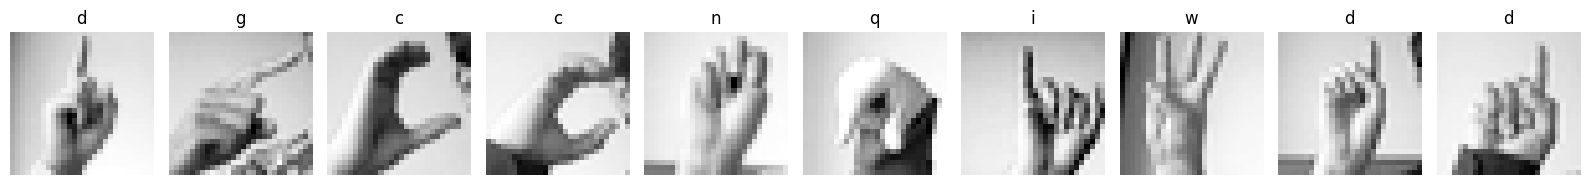

In [7]:
# This is a function to plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

# CNN Modelling

## Creating the Generators

this is to code the generators that will yield batches of images, both for training and validation.

In [8]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # adding another dimension for color to the data
  # because this is b&w images, the new dimension has a size of 1 instead of 3 (which is used for colored images)
  training_images = np.expand_dims(training_images, axis = -1)
  validation_images = np.expand_dims(validation_images, axis = -1)

  # instantiating the ImageDataGenerator class for training dataset
  train_datagen = ImageDataGenerator(
      rescale = 1./255.,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  # passing in the arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32)


  # instantiating the ImageDataGenerator class for validation dataset
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # passing in the arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32)

  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Building the Model Architecture

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    # 26 classes
    tf.keras.layers.Dense(26, activation='softmax')
  ])

model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

## Training the Model

In [18]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 18s 16ms/step - loss: 2.7132 - accuracy: 0.1670 - val_loss: 1.7756 - val_accuracy: 0.3825
Epoch 2/15
858/858 [==============================] - 13s 15ms/step - loss: 1.9146 - accuracy: 0.3843 - val_loss: 1.2676 - val_accuracy: 0.5593
Epoch 3/15
858/858 [==============================] - 13s 16ms/step - loss: 1.5091 - accuracy: 0.5094 - val_loss: 0.8978 - val_accuracy: 0.6845
Epoch 4/15
858/858 [==============================] - 13s 15ms/step - loss: 1.2465 - accuracy: 0.5895 - val_loss: 0.7201 - val_accuracy: 0.7328
Epoch 5/15
858/858 [==============================] - 13s 15ms/step - loss: 1.0866 - accuracy: 0.6422 - val_loss: 0.5682 - val_accuracy: 0.8040
Epoch 6/15
858/858 [==============================] - 13s 16ms/step - loss: 0.9569 - accuracy: 0.6826 - val_loss: 0.4764 - val_accuracy: 0.8240
Epoch 7/15
858/858 [==============================] - 14s 16ms/step - loss: 0.8640 - accuracy: 0.7144 - val_loss: 0.4653 - val_accuracy:

## Plotting the Accuracy and Loss

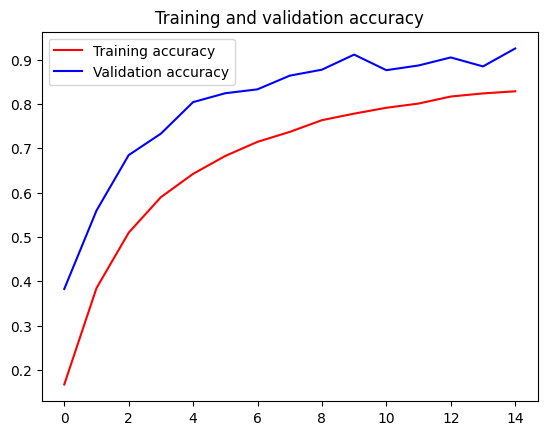

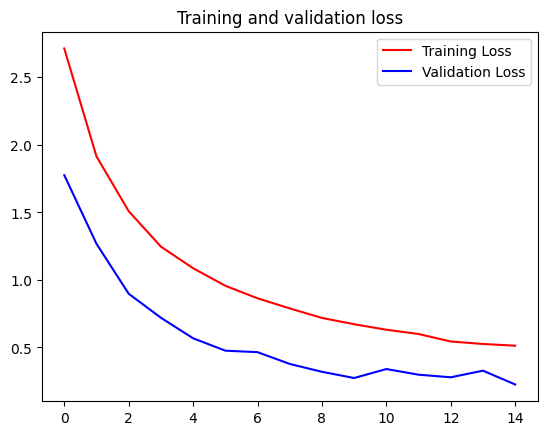

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# plot for training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plot for training and validation loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

In [22]:
predictions = model.predict(validation_images)

225/225 [==============================] - 1s 3ms/step


<ipython-input-44-90f986a591c6>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


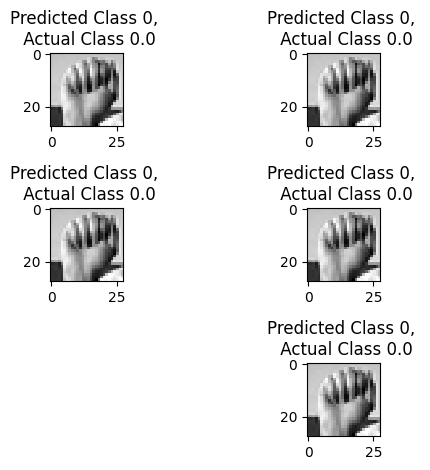

In [44]:
correct = np.nonzero(predictions == validation_labels.reshape(-1, 1))[0]
i = 0
for c in correct[:6]:
  plt.subplot(3,2,i+1)
  plt.imshow(validation_images[c], cmap="gray", interpolation='none')
  plt.title("Predicted Class {}, \n Actual Class {}".format(np.argmax(predictions[c]), validation_labels[c]))
  plt.tight_layout()
  i += 1